# Импорт

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations
from LookGenerator.networks.losses import PerceptualLoss, PerPixelLoss
from LookGenerator.datasets.encoder_decoder_datasets import EncoderDecoderDataset
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.clothes_feature_extractor import ClothAutoencoder
from LookGenerator.networks.encoder_decoder import EncoderDecoder
from LookGenerator.networks_training.utils import check_path_and_creat
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks.utils import load_model

# Загрузка данных

In [2]:
from torchvision.transforms import InterpolationMode

transform_human = transforms.Compose([
    transforms.Resize((256, 192)) #,
    # transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5])
])

transform_pose_points=transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.MinMaxScale()
])

transform_clothes = transforms.Compose([
    transforms.Resize((256, 192)),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

transform_human_restored = transforms.Compose([
    transforms.Resize((256, 192)),
    # transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    custom_transforms.MinMaxScale()
])


In [3]:
batch_size_train = 32
batch_size_val = 16
pin_memory = True
num_workers = 8

In [4]:
train_dataset = EncoderDecoderDataset(
    image_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\train",
    transform_human=transform_human,
    transform_clothes=transform_clothes,
    transform_human_restored=transform_human_restored
)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers
)

In [5]:
val_dataset = EncoderDecoderDataset(
    image_dir=r"C:\Users\DenisovDmitrii\Desktop\forEncoderNew\val",
    transform_human=transform_human,
    transform_clothes=transform_clothes,
    transform_human_restored=transform_human_restored,
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers
)

In [6]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([32, 6, 256, 192])
torch.Size([32, 3, 256, 192])


# Лосс

In [7]:
class EncoderDecoderLoss(nn.Module):
    """
    Encoder-decoder custom loss
    """
    def __init__(self, device='cpu'):
        super(EncoderDecoderLoss, self).__init__()
        self.perceptual_loss = PerceptualLoss(device, weights_perceptual=[1.0, 1.0, 1.0, 1.0])
        self.per_pixel_loss = PerPixelLoss().to(device)

    def forward(self, outputs, targets):
        loss = self.perceptual_loss(outputs, targets) + self.per_pixel_loss(outputs, targets)
        return loss

# Обучение модели

In [8]:
clothes_feature_extractor = ClothAutoencoder(
    in_channels=3,
    out_channels=3,
    features=(8, 16, 32, 64),
    latent_dim_size=128,
    encoder_activation_func=nn.LeakyReLU(),
    decoder_activation_func=nn.ReLU()
)
clothes_feature_extractor = load_model(clothes_feature_extractor, r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\autoDegradation\weights\testClothes_L1Loss_4features\epoch_39.pt")

In [9]:
model = EncoderDecoder(clothes_feature_extractor, in_channels=6, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = EncoderDecoderLoss(device=device)
print(device)

C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [10]:
save_directory=r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\newEncoder\weights\testDoubleClothes"
check_path_and_creat(save_directory)

True

In [11]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [12]:
trainer = Trainer(
    model_=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_directory=save_directory,
    save_step=1,
    verbose=True
)

In [13]:
trainer.train(train_dataloader, val_dataloader, epoch_num=20)

start time 31-05-2023 12:36


  0%|          | 0/364 [00:00<?, ?it/s]C:\Users\DenisovDmitrii\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 364/364 [06:26<00:00,  1.06s/it]


Epoch 0 of 19, train loss: 3.33374
Epoch end time 31-05-2023 12:43


100%|██████████| 127/127 [00:25<00:00,  4.95it/s]


Epoch 0 of 19, val loss: 2.79613
Epoch end time 31-05-2023 12:43


100%|██████████| 364/364 [04:34<00:00,  1.33it/s]


Epoch 1 of 19, train loss: 2.49311
Epoch end time 31-05-2023 12:48


100%|██████████| 127/127 [00:24<00:00,  5.15it/s]


Epoch 1 of 19, val loss: 3.00698
Epoch end time 31-05-2023 12:48


100%|██████████| 364/364 [03:06<00:00,  1.95it/s]


Epoch 2 of 19, train loss: 2.33267
Epoch end time 31-05-2023 12:51


100%|██████████| 127/127 [00:24<00:00,  5.10it/s]


Epoch 2 of 19, val loss: 2.85367
Epoch end time 31-05-2023 12:52


100%|██████████| 364/364 [04:11<00:00,  1.45it/s]


Epoch 3 of 19, train loss: 2.23664
Epoch end time 31-05-2023 12:56


100%|██████████| 127/127 [00:24<00:00,  5.15it/s]


Epoch 3 of 19, val loss: 2.55635
Epoch end time 31-05-2023 12:56


100%|██████████| 364/364 [03:24<00:00,  1.78it/s]


Epoch 4 of 19, train loss: 2.17106
Epoch end time 31-05-2023 13:00


100%|██████████| 127/127 [00:24<00:00,  5.19it/s]


Epoch 4 of 19, val loss: 2.37343
Epoch end time 31-05-2023 13:00


100%|██████████| 364/364 [03:22<00:00,  1.79it/s]


Epoch 5 of 19, train loss: 2.11904
Epoch end time 31-05-2023 13:04


100%|██████████| 127/127 [00:24<00:00,  5.12it/s]


Epoch 5 of 19, val loss: 2.32335
Epoch end time 31-05-2023 13:04


100%|██████████| 364/364 [03:23<00:00,  1.79it/s]


Epoch 6 of 19, train loss: 2.07247
Epoch end time 31-05-2023 13:07


100%|██████████| 127/127 [00:24<00:00,  5.24it/s]


Epoch 6 of 19, val loss: 2.99310
Epoch end time 31-05-2023 13:08


100%|██████████| 364/364 [03:27<00:00,  1.75it/s]


Epoch 7 of 19, train loss: 2.03410
Epoch end time 31-05-2023 13:11


100%|██████████| 127/127 [00:24<00:00,  5.10it/s]


Epoch 7 of 19, val loss: 2.33559
Epoch end time 31-05-2023 13:12


100%|██████████| 364/364 [03:24<00:00,  1.78it/s]


Epoch 8 of 19, train loss: 1.99526
Epoch end time 31-05-2023 13:15


100%|██████████| 127/127 [00:24<00:00,  5.23it/s]


Epoch 8 of 19, val loss: 2.24575
Epoch end time 31-05-2023 13:16


100%|██████████| 364/364 [03:34<00:00,  1.70it/s]


Epoch 9 of 19, train loss: 1.96167
Epoch end time 31-05-2023 13:19


100%|██████████| 127/127 [00:25<00:00,  5.00it/s]


Epoch 9 of 19, val loss: 2.23124
Epoch end time 31-05-2023 13:20


100%|██████████| 364/364 [04:12<00:00,  1.44it/s]


Epoch 10 of 19, train loss: 1.92615
Epoch end time 31-05-2023 13:24


100%|██████████| 127/127 [00:26<00:00,  4.86it/s]


Epoch 10 of 19, val loss: 2.16187
Epoch end time 31-05-2023 13:24


100%|██████████| 364/364 [04:13<00:00,  1.44it/s]


Epoch 11 of 19, train loss: 1.88984
Epoch end time 31-05-2023 13:28


100%|██████████| 127/127 [00:25<00:00,  5.06it/s]


Epoch 11 of 19, val loss: 2.12352
Epoch end time 31-05-2023 13:29


100%|██████████| 364/364 [03:37<00:00,  1.67it/s]


Epoch 12 of 19, train loss: 1.85630
Epoch end time 31-05-2023 13:32


100%|██████████| 127/127 [00:24<00:00,  5.15it/s]


Epoch 12 of 19, val loss: 2.66901
Epoch end time 31-05-2023 13:33


100%|██████████| 364/364 [03:46<00:00,  1.61it/s]


Epoch 13 of 19, train loss: 1.82099
Epoch end time 31-05-2023 13:37


100%|██████████| 127/127 [00:25<00:00,  5.03it/s]


Epoch 13 of 19, val loss: 2.26055
Epoch end time 31-05-2023 13:37


100%|██████████| 364/364 [03:26<00:00,  1.76it/s]


Epoch 14 of 19, train loss: 1.78490
Epoch end time 31-05-2023 13:41


100%|██████████| 127/127 [00:23<00:00,  5.31it/s]


Epoch 14 of 19, val loss: 2.36441
Epoch end time 31-05-2023 13:41


100%|██████████| 364/364 [03:20<00:00,  1.81it/s]


Epoch 15 of 19, train loss: 1.75108
Epoch end time 31-05-2023 13:44


100%|██████████| 127/127 [00:24<00:00,  5.19it/s]


Epoch 15 of 19, val loss: 2.28397
Epoch end time 31-05-2023 13:45


100%|██████████| 364/364 [03:18<00:00,  1.83it/s]


Epoch 16 of 19, train loss: 1.71943
Epoch end time 31-05-2023 13:48


100%|██████████| 127/127 [00:24<00:00,  5.29it/s]


Epoch 16 of 19, val loss: 2.35740
Epoch end time 31-05-2023 13:48


100%|██████████| 364/364 [02:59<00:00,  2.03it/s]


Epoch 17 of 19, train loss: 1.68388
Epoch end time 31-05-2023 13:51


100%|██████████| 127/127 [00:23<00:00,  5.29it/s]


Epoch 17 of 19, val loss: 2.14883
Epoch end time 31-05-2023 13:52


100%|██████████| 364/364 [03:10<00:00,  1.91it/s]


Epoch 18 of 19, train loss: 1.65037
Epoch end time 31-05-2023 13:55


100%|██████████| 127/127 [00:24<00:00,  5.16it/s]


Epoch 18 of 19, val loss: 2.13923
Epoch end time 31-05-2023 13:55


100%|██████████| 364/364 [03:50<00:00,  1.58it/s]


Epoch 19 of 19, train loss: 1.62356
Epoch end time 31-05-2023 13:59


100%|██████████| 127/127 [00:26<00:00,  4.85it/s]

Epoch 19 of 19, val loss: 2.18130
Epoch end time 31-05-2023 14:00
end time 31-05-2023 14:00
delta 1:23:11.532322


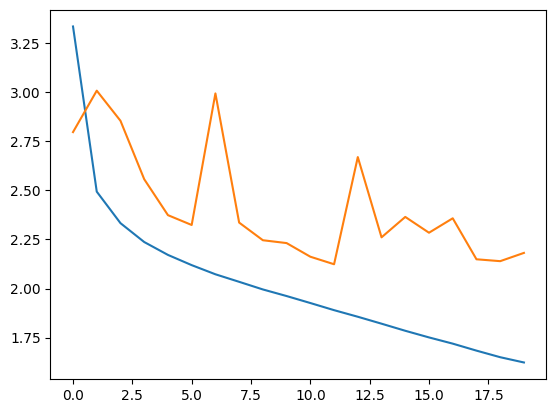

In [14]:
trainer.draw_history_plots()

In [15]:
print(str(trainer))

Model:
	Encoder-decoder: 
	base model 
Autoencoder: 
	features: (8, 16, 32, 64), latent_size: 128
Criterion: 
	<class '__main__.EncoderDecoderLoss'>
Optimizer: 
	<class 'torch.optim.adam.Adam'>


In [17]:
from torchsummary import summary
summary(model.to('cuda'), (6, 256, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 192]           3,520
         LeakyReLU-2         [-1, 64, 256, 192]               0
         LeakyReLU-3         [-1, 64, 256, 192]               0
           Conv3x3-4         [-1, 64, 256, 192]               0
            Conv2d-5         [-1, 64, 256, 192]          36,928
           Conv3x3-6         [-1, 64, 256, 192]               0
         LeakyReLU-7         [-1, 64, 256, 192]               0
         LeakyReLU-8         [-1, 64, 256, 192]               0
           Conv5x5-9         [-1, 64, 256, 192]               0
           Conv2d-10         [-1, 64, 256, 192]          36,928
        LeakyReLU-11         [-1, 64, 256, 192]               0
        LeakyReLU-12         [-1, 64, 256, 192]               0
          Conv3x3-13         [-1, 64, 256, 192]               0
           Conv2d-14         [-1, 64, 2

In [18]:
file = open(os.path.join(save_directory, "readme.txt"), 'w')
file.write(str(trainer))
file.write("\n")
file.write(str(summary(model.to('cuda'), (6, 256, 192))))
file.close()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 192]           3,520
         LeakyReLU-2         [-1, 64, 256, 192]               0
         LeakyReLU-3         [-1, 64, 256, 192]               0
           Conv3x3-4         [-1, 64, 256, 192]               0
            Conv2d-5         [-1, 64, 256, 192]          36,928
           Conv3x3-6         [-1, 64, 256, 192]               0
         LeakyReLU-7         [-1, 64, 256, 192]               0
         LeakyReLU-8         [-1, 64, 256, 192]               0
           Conv5x5-9         [-1, 64, 256, 192]               0
           Conv2d-10         [-1, 64, 256, 192]          36,928
        LeakyReLU-11         [-1, 64, 256, 192]               0
        LeakyReLU-12         [-1, 64, 256, 192]               0
          Conv3x3-13         [-1, 64, 256, 192]               0
           Conv2d-14         [-1, 64, 2

In [ ]:
trainer.train(train_dataloader, val_dataloader, epoch_num=20)

In [ ]:
trainer.draw_history_plots()